In [199]:
import string
import numpy as np
import requests
import matplotlib.pyplot as plt
from colorama import Fore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics._classification import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from collections import defaultdict



In [3]:
alan=requests.get('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt')
alan=alan.text

robert=requests.get('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt')
robert=robert.text

In [4]:
import string

labels=[]
lines=[]

poets=[alan, robert]
for idx, poet in enumerate(poets):
    for line in poet.split('\n'):
        if line:
            line=line.translate(str.maketrans('', '', string.punctuation))
            lines.append(line.lower())
            labels.append(idx) 


In [5]:
len(lines)==len(labels)

True

In [156]:
X_train, X_test, y_train, y_test = train_test_split(lines, labels, test_size=0.35, shuffle=True)
len(X_train), len(X_test)

(1402, 756)

In [157]:
540/len(lines)*100

25.023169601482852

In [158]:
X_train[:5], y_train[:5]

(['oh hasten oh let us not linger',
  'my duty to be saved by their bright light ',
  'estelles to take me when shes settled down ',
  'of castles i used to build in air',
  'shall be an endless theme of praise'],
 [0, 0, 1, 1, 0])

In [159]:
word2idx=defaultdict(int)
word2idx['UNK']=0
idx=1
for line in X_train:
    for word in line.split():
        if word not in word2idx:
            word2idx[word]=idx
            idx+=1

vocab_size=len(word2idx)
print(f'length of vocabulary {vocab_size}')


length of vocabulary 2287


In [160]:
train_text_as_int=[]
test_text_as_int=[]
for line in X_train:
    tokens=line.split()
    line_as_int=[word2idx[token] for token in tokens]
    train_text_as_int.append(line_as_int)

for line in X_test:
    tokens=line.split()
    line_as_int=[word2idx.get(token, 0) for token in tokens]
    test_text_as_int.append(line_as_int)

In [161]:
print(Fore.RED+str(train_text_as_int[:3]))

[[1, 2, 1, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 15], [16, 9, 17, 18, 19, 20, 21, 22]]


In [162]:
V=len(word2idx)

A0=np.ones((V, V))
p0=np.ones(V,)

A1=np.ones((V, V))
p1=np.ones(V,)

In [163]:
assert len(X_train)==len(y_train)

In [164]:
def compute_matrix(text_as_int, A, p):
    for tokens in text_as_int:
        last_idx=None
        for idx in tokens:
            if last_idx is None:
                p[idx]+=1
            else:
                A[last_idx, idx]+=1
            last_idx=idx
    return A, p

A0, p0=compute_matrix([t for t, y in zip(train_text_as_int, y_train) if y==0], A0, p0)
A1, p1=compute_matrix([t for t, y in zip(train_text_as_int, y_test) if y==1], A1, p1)

In [165]:
max(A0[346])

1.0

In [166]:
#convert matrix to the respective probability matrix
A0/=A0.sum(axis=1, keepdims=True)
A1/=A1.sum(axis=1, keepdims=True)
p0/=p0.sum(keepdims=True)
p1/=p1.sum(keepdims=True)

In [167]:
# print shapes of preprocessed matrix
print(f'{Fore.RED}A0 shape {Fore.CYAN} {A0.shape}')
print(f'{Fore.RED}A1 shape {Fore.CYAN} {A1.shape}')
print(f'{Fore.RED}p0 shape {Fore.CYAN} {p0.shape}')
print(f'{Fore.RED}p1 shape {Fore.CYAN} {p1.shape}')

A0 shape  (2287, 2287)
A1 shape  (2287, 2287)
p0 shape  (2287,)
p1 shape  (2287,)


In [168]:
A0[4]

array([0.00043309, 0.00043309, 0.00043309, ..., 0.00043309, 0.00043309,
       0.00043309])

In [169]:
#convert to log probs
logA0=np.log(A0)
logA1=np.log(A1)
logp0=np.log(p0)
logp1=np.log(p1)

In [170]:
label0_count=sum([y==0 for y in y_train])
label1_count=sum([y==1 for y in y_train])

total_count=len(y_train)

log_prior_0=np.log(label0_count/total_count)
log_prior_1=np.log(label1_count/total_count)

log_prior_0, log_prior_1

(-1.1209716767003306, -0.39447014010079273)

In [171]:
(label0_count/total_count), (label1_count/total_count)

(0.325962910128388, 0.6740370898716119)

In [172]:
# create classifier
class HMM:
    def __init__(self, As, ps, log_priors):
        self.As=As
        self.ps=ps
        self.log_priors=log_priors
        self.K=len(self.log_priors)

    def compute_max_likelihood(self, inputs, class_):
        logA=self.As[class_]
        logps=self.ps[class_]
        last_idx=None
        log_likelihood=0
        for i in inputs:
            if last_idx is None:
                log_likelihood+=logps[i]
            else:
                log_likelihood+=logA[last_idx, i]
            last_idx=i
        return log_likelihood
    
    def predict(self, inputs_):
        predictions=[]
        for input_ in inputs_:
            posterior=[self.compute_max_likelihood(input_, c)+self.log_priors[c] for c in range(self.K)]
            max_pred=np.argmax(posterior)
            predictions.append(max_pred)
        return predictions

In [173]:
clf=HMM([logA0, logA1], [logp0, logp1], [log_prior_0, log_prior_1])
y_train_pred=clf.predict(train_text_as_int)
y_test_pred=clf.predict(test_text_as_int)
print(f'Train Accuracy:{accuracy_score(y_train,y_train_pred)}')
print(f'Test Accuracy:{accuracy_score(y_test,y_test_pred)}')

Train Accuracy:0.8972895863052782
Test Accuracy:0.75


In [194]:
idx2poets={
    0:'Alan',
    1:'Robert'
}

In [195]:
def predict(sentence):
    tokens=sentence.split()
    line_as_int=[word2idx.get(token, 0) for token in tokens]
    return idx2poets[clf.predict([line_as_int])[0]]

# Sample example to test the predict function
print("Predicted:", predict('here Achilles and Diomed rest. \n\nIn fresh myrtle my blade I\'ll entwine,\nLike Harmodious, the gallant and good,\nWhen he made at the tutelar shrine\nA libation of Tyranny\'s blood.'))
print("Actual:", 'Alan')

Predicted: Alan
Actual: Alan


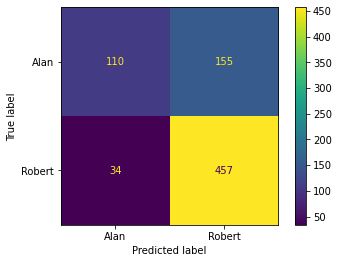

In [205]:
cm=confusion_matrix(y_test,y_test_pred)
cmd=ConfusionMatrixDisplay(cm, display_labels=['Alan', 'Robert'])
cmd.plot()
plt.show()

In [192]:
import gradio as gr

gr.Interface(predict, inputs='text', outputs='text').launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x26ce59da580>, 'http://127.0.0.1:7860/', None)

Exception in callback None(<Task finishe...> result=None>)
handle: <Handle>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
TypeError: 'NoneType' object is not callable
